# RR Lyrae Map for Pisces Region

Following Belokurov et al. 2019 methodology to map RR Lyrae in the Pisces region using fixed absolute magnitude approach.

In [21]:
import numpy as np
import sqlutilpy as sqlutil
import matplotlib.pyplot as plt
import astropy.table as atpy
import pandas as pd
from astropy.coordinates import SkyCoord
import astropy.units as u

import matplotlib.colors as mcolors
from matplotlib.colors import LogNorm

In [34]:
# Survey box (in RA[-180,+180], Dec deg)
tarx = [-45.0,  15.0]
tary = [-20.0,   0.0]

def draw_survey_box():
    """Outline the RA/Dec survey rectangle in red."""
    plt.plot(
        [tarx[0], tarx[1], tarx[1], tarx[0], tarx[0]],
        [tary[0], tary[0], tary[1], tary[1], tary[0]],
        color="red", linewidth=2, solid_capstyle="round", label="Survey region"
    )

In [14]:
# Query Gaia DR3 RR Lyrae data for Pisces region following Belokurov et al. 2019
# Pisces region: RA ~ -10° to +15° (350° to 15°), Dec ~ -20° to 0°
# Distance range: 40-110 kpc as observed in the paper

query = """
SELECT
  v.source_id,
  g.ra, g.dec,
  g.parallax, g.parallax_error,
  g.pmra, g.pmdec, g.pmra_error, g.pmdec_error,
  g.phot_g_mean_mag, g.bp_rp, g.phot_bp_rp_excess_factor,
  g.ruwe, g.ebv, 
  v.pf, v.metallicity, v.int_average_g, v.peak_to_peak_g, v.best_classification
FROM   gaia_dr3.vari_rrlyrae AS v
JOIN   gaia_dr3.gaia_source AS g USING (source_id)
"""

# Execute query using sqlutil
print("Querying Gaia DR3 RR Lyrae data...")
X = sqlutil.get(query, asDict=True)
print(f"Retrieved  {len(next(iter(X.values())))} RR Lyrae stars")

Querying Gaia DR3 RR Lyrae data...
Retrieved  271779 RR Lyrae stars


In [15]:
# Convert to pandas DataFrame for easier manipulation
df = pd.DataFrame(X)
df = df[df['best_classification'] == 'RRab'].copy()
print(f"Number of RRab: {df.shape[0]}")
print(f"Data shape: {df.shape}")
print(f"Columns: {list(df.columns)}")
print(f"G-band magnitude range: {df['phot_g_mean_mag'].min():.2f} - {df['phot_g_mean_mag'].max():.2f}")

Number of RRab: 175350
Data shape: (175350, 19)
Columns: ['source_id', 'ra', 'dec', 'parallax', 'parallax_error', 'pmra', 'pmdec', 'pmra_error', 'pmdec_error', 'phot_g_mean_mag', 'bp_rp', 'phot_bp_rp_excess_factor', 'ruwe', 'ebv', 'pf', 'metallicity', 'int_average_g', 'peak_to_peak_g', 'best_classification']
G-band magnitude range: 7.62 - 21.19


In [16]:
# --- Heliocentric distances for RRab with a fixed absolute magnitude ---

# Use intensity-averaged G when available; fall back to catalog mean if missing
g_mean = df['int_average_g'].where(df['int_average_g'].notna(), df['phot_g_mean_mag'])

# Extinction: A_G = k_G * E(B-V). For RR Lyrae colors (BP-RP ~ 0.3–0.6),
# a constant k_G ≈ 2.5 is a sensible, conservative choice.
# Guard against tiny negative E(B-V) by clipping at 0.
kG = 2.5
ebv = df['ebv'].clip(lower=0.0)
A_G = kG * ebv

# Fixed absolute magnitude for RRab (see notes): use ~0.63 mag rather than 0.47
M_G_rrab = 0.63

# Extinction-corrected apparent magnitude
g0 = g_mean - A_G

# Distance modulus and distance
mu = g0 - M_G_rrab
# Use np.power for vectorization and protect against NaNs/infs
distance_pc = np.power(10.0, (mu + 5.0) / 5.0)
distance_kpc = distance_pc / 1_000.0

# Store results
df['g_corrected'] = g0
df['distance_modulus'] = mu
df['distance_kpc'] = distance_kpc

# Basic stats (ignoring NaNs)
d = df['distance_kpc'].astype(float)
print(f"Distance range: {np.nanmin(d):.1f} - {np.nanmax(d):.1f} kpc")
print(f"Mean distance: {np.nanmean(d):.1f} kpc")
print(f"Median distance: {np.nanmedian(d):.1f} kpc")

Distance range: 0.0 - 115.7 kpc
Mean distance: 22.7 kpc
Median distance: 15.6 kpc


N_RRab (30–80 kpc) = 36,879


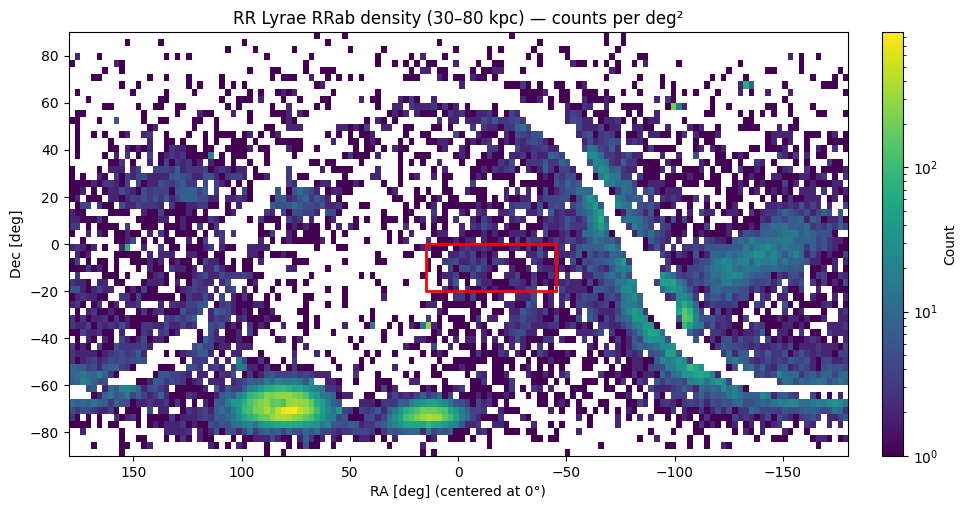

In [39]:

# --- Select RRab between 30 and 80 kpc ---
mask_dist = df['distance_kpc'].between(40.0, 100.0)

sel = df[mask_dist].copy()

# RA in [0, 360)
ra = (sel['ra'].to_numpy() % 360.0)
dec = np.clip(sel['dec'].to_numpy(), -90.0, 90.0)

# --- Wrap RA to [-180, +180) so 0/360 sits at the center ---
ra_wrap = ((ra + 180.0) % 360.0) - 180.0

# --- 2D histogram in 1° bins (counts per deg²) ---
ra_edges = np.linspace(-180.0, 180.0, 141)  # RA centered on 0°
dec_edges = np.linspace(-90.0, 90.0, 61)

H, ra_e, dec_e = np.histogram2d(ra_wrap, dec, bins=[ra_edges, dec_edges])

# --- Plot ---
fig = plt.figure(figsize=(11, 5.5))
ax = plt.gca()

im = ax.imshow(
    H.T,
    extent=[ra_edges[0], ra_edges[-1], dec_edges[0], dec_edges[-1]],
    origin='lower',
    aspect='auto',
    norm=LogNorm(vmin=1, vmax=max(1, H.max()))
)

# Flip RA so it increases to the left; with wrapping, left=+180, right=-180, center=0
ax.set_xlim(180, -180)
ax.set_xlabel("RA [deg] (centered at 0°)")
ax.set_ylabel("Dec [deg]")
ax.set_title("RR Lyrae RRab density (30–80 kpc) — counts per deg²")

draw_survey_box()

cbar = plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
cbar.set_label("Count")

print(f"N_RRab (30–80 kpc) = {sel.shape[0]:,}")
plt.show()

In [ ]:
# Save the data for further analysis
output_file = '../gaiadr3_rrab_data.fits'
atpy.Table.from_pandas(df).write(output_file, overwrite=True)
print(f"Saved {len(df)} RR Lyrae stars to {output_file}")

Saved 175350 RR Lyrae stars to gaiadr3_rrab_data.fits
